# Predicting Stock Profitability with Decision Tree Classification

---

## Environment Setup

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

---
## Load Data

In [2]:
import glob

path = r'./Financial_Data'
all_files = glob.glob(path+"/*.csv")

files_list = []

for file, year in zip(all_files, range(2014,2019)):
    df = pd.read_csv(file, index_col='Unnamed: 0', header=0)
    files_list.append(df)
    print(f"Dimensions of {year} dataset: {df.shape}")

Dimensions of 2014 dataset: (3808, 224)
Dimensions of 2015 dataset: (4120, 224)
Dimensions of 2016 dataset: (4797, 224)
Dimensions of 2017 dataset: (4960, 224)
Dimensions of 2018 dataset: (4392, 224)


Since 2017 dataset has the most samples, we will use this dataset to train our model and test it on the latest (2018) dataset.

In [3]:
df_2014 = files_list[0]
df_2015 = files_list[1]
df_2016 = files_list[2]
df_2017 = files_list[3]
df_2018 = files_list[4]

### Overview of the 2017 dataframe
Top five entries:

In [4]:
df_2017.head(5)

,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,Income Tax Expense,Net Income - Non-Controlling int,Net Income - Discontinued ops,Net Income,Preferred Dividends,Net Income Com,EPS,EPS Diluted,Weighted Average Shs Out,Weighted Average Shs Out (Dil),Dividend per Share,Gross Margin,EBITDA Margin,EBIT Margin,Profit Margin,Free Cash Flow margin,EBITDA,EBIT,Consolidated Income,Earnings Before Tax Margin,Net Profit Margin,Cash and cash equivalents,Short-term investments,Cash and short-term investments,Receivables,Inventories,Total current assets,"Property, Plant & Equipment Net",Goodwill and Intangible Assets,Long-term investments,Tax assets,Total non-current assets,Total assets,Payables,Short-term debt,Total current liabilities,Long-term debt,Total debt,Deferred revenue,Tax Liabilities,Deposit Liabilities,Total non-current liabilities,Total liabilities,Other comprehensive income,Retained earnings (deficit),Total shareholders equity,Investments,Net Debt,Other Assets,Other Liabilities,Depreciation & Amortization,Stock-based compensation,Operating Cash Flow,Capital Expenditure,Acquisitions and disposals,Investment purchases and sales,Investing Cash flow,Issuance (repayment) of debt,Issuance (buybacks) of shares,Dividend payments,Financing Cash Flow,Effect of forex changes on cash,Net cash flow / Change in cash,Free Cash Flow,Net Cash/Marketcap,priceBookValueRatio,priceToBookRatio,priceToSalesRatio,priceEarningsRatio,priceToFreeCashFlowsRatio,priceToOperatingCashFlowsRatio,priceCashFlowRatio,priceEarningsToGrowthRatio,priceSalesRatio,dividendYield,enterpriseValueMultiple,priceFairValue,ebitperRevenue,ebtperEBIT,niperEBT,grossProfitMargin,operatingProfitMargin,pretaxProfitMargin,netProfitMargin,effectiveTaxRate,returnOnAssets,returnOnEquity,returnOnCapitalEmployed,nIperEBT,eBTperEBIT,eBITperRevenue,payablesTurnover,inventoryTurnover,fixedAssetTurnover,assetTurnover,currentRatio,quickRatio,cashRatio,daysOfSalesOutstanding,daysOfInventoryOutstanding,operatingCycle,daysOfPayablesOutstanding,cashConversionCycle,debtRatio,debtEquityRatio,longtermDebtToCapitalization,totalDebtToCapitalization,interestCoverage,cashFlowToDebtRatio,companyEquityMultiplier,operatingCashFlowPerShare,freeCashFlowPerShare,cashPerShare,payoutRatio,operatingCashFlowSalesRatio,freeCashFlowOperatingCashFlowRatio,cashFlowCoverageRatios,shortTermCoverageRatios,capitalExpenditureCoverageRatios,dividendpaidAndCapexCoverageRatios,dividendPayoutRatio,Revenue per Share,Net Income per Share,Operating Cash Flow per Share,Free Cash Flow per Share,Cash per Share,Book Value per Share,Tangible Book Value per Share,Shareholders Equity per Share,Interest Debt per Share,Market Cap,Enterprise Value,PE ratio,Price to Sales Ratio,POCF ratio,PFCF ratio,PB ratio,PTB ratio,EV to Sales,Enterprise Value over EBITDA,EV to Operating cash flow,EV to Free cash flow,Earnings Yield,Free Cash Flow Yield,Debt to Equity,Debt to Assets,Net Debt to EBITDA,Current ratio,Interest Coverage,Income Quality,Dividend Yield,Payout Ratio,SG&A to Revenue,R&D to Revenue,Intangibles to Total Assets,Capex to Operating Cash Flow,Capex to Revenue,Capex to Depreciation,Stock-based compensation to Revenue,Graham Number,ROIC,Return on Tangible Assets,Graham Net-Net,Working Capital,Tangible Asset Value,Net Current Asset Value,Invested Capital,Average Receivables,Average Payables,Average Inventory,Days Sales Outstanding,Days Payables Outstanding,Days of Inventory on Hand,Receivables Turnover,Payables Turnover,Inventory Turnover,ROE,Capex per Share,Gross Profit Growth,EBIT Growth,Operating Income Growth,Net Income Growth,EPS Growth,EPS Diluted Growth,Weighted Average Shares Growth,Weighted Average Shares Diluted Growth,Dividends per Share Growth,Operating Cash Flow growth,Free Cash Flow growth,10Y Revenue Growth (per Share),5Y Revenue Growth (per Share),3Y Revenue Growth (per Share),10Y Operating CF Growth (per Share),5Y Op

### Summary statistics of 2017 dataset

In [5]:
#df_2017.describe(include='all').T

Soon we can find among the 224 variables, 221 of them are financial indicators. PRICE VAR is the price variance of the stock, and Class is an identifier of PRICE VAR. Class equals unity if PRICE VAR is positive, and equals zero if PRICE VAR is negative.

#### Distribution of stock classes:

In [6]:
df_2017['Class'].value_counts().sort_index()

0    3590
1    1370
Name: Class, dtype: int64

<function matplotlib.pyplot.show(*args, **kw)>

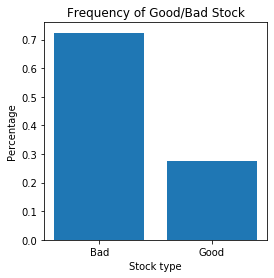

In [7]:
plt.figure(figsize=(4,4))
class_perc = df_2017['Class'].value_counts().sort_index()/len(df_2017)
# Notes 70% of the stocks are bad stocks

plt.bar(range(2), class_perc.values)
plt.title("Frequency of Good/Bad Stock")
plt.xticks(range(2),("Bad","Good"))
plt.xlabel("Stock type")
plt.ylabel("Percentage")

#plt.savefig('/Graph/stock_class_2017.png', dpi=100)
plt.show

Findings:
* 70% of the stocks are not profitable with negative price variance.

#### Distribution of Sectors by stock Class:

In [8]:
# distribution of Sectors
df_2017['Sector'].value_counts()

Financial Services        1247
Healthcare                 718
Technology                 665
Industrials                595
Consumer Cyclical          520
Basic Materials            282
Energy                     266
Real Estate                264
Consumer Defensive         199
Utilities                  110
Communication Services      94
Name: Sector, dtype: int64

<function matplotlib.pyplot.show(*args, **kw)>

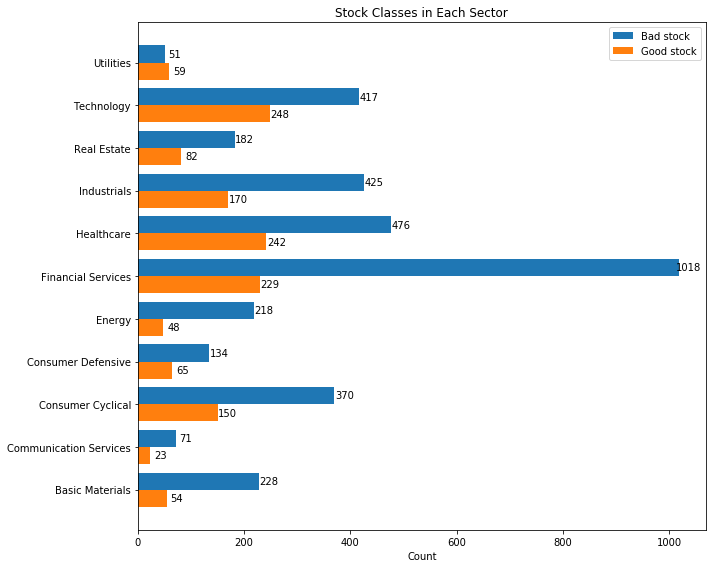

In [9]:
sector_counts_0 = df_2017[df_2017['Class']==0]['Sector'].value_counts().sort_index()
sector_counts_1 = df_2017[df_2017['Class']==1]['Sector'].value_counts().sort_index()

labels = list(sector_counts_0.keys())

y = np.arange(len(labels))
width = 0.4

fig, ax = plt.subplots(figsize=(10,8))

rects1 = ax.barh(y + width/2, sector_counts_0.values, width, label='Bad stock')
rects2 = ax.barh(y - width/2, sector_counts_1.values, width, label='Good stock')

ax.set_title("Stock Classes in Each Sector")
ax.set_xlabel('Count')
ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        width = rect.get_width()
        ax.annotate('{}'.format(width),
                    xy=(width, rect.get_y() + rect.get_height()/2),
                    xytext=(10,0),
                    textcoords='offset points',
                    ha='center',
                    va='center')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

#fig.savefig('/Graph/final_sector_plot-original.png', dpi=100)
plt.show

Findings:
* Most of the samples are from the fiancial services sector.
* The utilities sector shows a different trend compared to other sectors - more good stocks than bad ones. 

## Data Cleaning
### 1) Drop duplicate columns
After an initial investigation, we found there are some columns with the same values and columns with same names. We decided to remove repetitive columns. 
#### Drop columns with same values
For columns with same values, we keep the first one in the dataframe.

In [10]:
col_names_bf = list(df_2017.columns)
df_2017 = df_2017.T.drop_duplicates().T.infer_objects()
col_names_af = list(df_2017.columns)
dup_cols = [col for col in col_names_bf if col not in col_names_af]

print(f"Dropped column names: {dup_cols}\n")
print(f"Dimension after dropping duplicate columns: {df_2017.shape}")

Dropped column names: ['nIperEBT', 'eBTperEBIT', 'eBITperRevenue', 'cashFlowCoverageRatios', 'Operating Cash Flow per Share', 'Free Cash Flow per Share', 'Cash per Share', 'PE ratio', 'Price to Sales Ratio', 'POCF ratio', 'PFCF ratio', 'PB ratio', 'PTB ratio', 'Debt to Equity', 'Debt to Assets', 'Interest Coverage', 'Payout Ratio', 'ROIC', 'Return on Tangible Assets', 'Days Payables Outstanding', 'Days of Inventory on Hand', 'Payables Turnover', 'Inventory Turnover', 'ROE']

Dimension after dropping duplicate columns: (4960, 200)


#### Drop columns with same names
Current ratio, dividend yield, and net profit margin have repeated entries with different data. Since the number of missing values are different in each of these variables, we choose the one with less missing values. 

In [11]:
# find duplicated columns
# df = df_2017.copy()
# df.columns = map(str.lower, df.columns)
# df.sort_index(axis=1, inplace=True)
# df.isna().sum()
# # df_cols = list(df_2017.columns)
# # df_cols.sort()
# # df_cols

Summary statistics of columns with same names but different values:

In [12]:
dup_cols = ['currentRatio','Current ratio','dividendYield', 'Dividend Yield', 'netProfitMargin','Net Profit Margin']

df_2017[dup_cols].describe()

,currentRatio,Current ratio,dividendYield,Dividend Yield,netProfitMargin,Net Profit Margin
count,4141.000000,3266.000000,4074.000000,4128.000000,4035.000000,4299.000000
mean,8.002848,7.066240,0.239612,0.021061,-9.747367,-9.100791
std,157.646093,152.561462,6.613889,0.247327,387.360298,375.292338
min,-1.300000,-1.300000,-0.000000,0.000000,-24414.000000,-24414.000000
25%,0.897000,1.139250,-0.000000,0.000000,-0.034624,-0.029900
50%,1.727000,1.891000,-0.000000,0.000000,0.045056,0.042700
75%,3.165000,3.320500,0.021158,0.019125,0.141231,0.141050
max,7455.691000,7455.691000,369.533814,14.550000,155.336618,156.461538


In [13]:
dup_cols_drop = ['Current ratio','dividendYield','netProfitMargin']
df_2017.drop(dup_cols_drop, axis=1,inplace=True)

print(f"Dimension after dropping duplicate columns: {df_2017.shape}")

Dimension after dropping duplicate columns: (4960, 197)


### 2) Handle Missing Values

In [14]:
print(f"Average number of missing values: {df_2017.isna().sum().mean()}")

Average number of missing values: 994.3604060913706


#### Remove columns with over 1,000 missing values
On average, there are 995 missing values in each column, which rounds up as 1000. Thus, we decided not to use these indicators as columns with over 1,000 missing values are considered lacking representativeness and completeness.

In [15]:
unrep_cols = [col for col in df_2017.columns if df_2017[col].isna().sum() > 1000]
df_2017.drop(unrep_cols,axis=1,inplace=True)

print(f"Dimensions after removing columns with over 1000 nulls: {df_2017.shape}")

Dimensions after removing columns with over 1000 nulls: (4960, 143)


#### Remove rows with missing values

In [16]:
#print(f"Dimensions before removing missing values: {finance_all.shape}")
df_2017 = df_2017.dropna() 
print(f"Dimensions after removing missing values: {df_2017.shape}")

# fill in missing values with mean value instead
# df_2017_impute_na = df_2017_cleaned.fillna(df_2017_cleaned.mean())

Dimensions after removing missing values: (3644, 143)


### 3) Drop outliers
Since data has extreme values that are caused by miss typing, datapoints that are outside 99 percentiles or 1 percentiles are omitted.

In [17]:
# Calculate IQR score
P1 = df_2017.quantile(0.01)
P99 = df_2017.quantile(0.99)

# Remove outliers outside 1 and 99 percentiles
df_2017 = df_2017[~((df_2017 < P1) | (df_2017 > P99)).any(axis=1)]

print(f"Number of samples after removing outliers: {len(df_2017)}")
print(f"Dimension of after removing outliers dataset: {df_2017.shape}")

Number of samples after removing outliers: 1736
Dimension of after removing outliers dataset: (1736, 143)


## Distribution of Class and Sectors
To ensure our data cleaning process does not change the distributions of the outcome variable (Class) and Sectors, we printed out the distributions of these two variables again. 

<function matplotlib.pyplot.show(*args, **kw)>

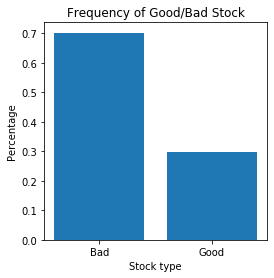

In [18]:
plt.figure(figsize=(4,4))
class_perc = df_2017['Class'].value_counts().sort_index()/len(df_2017)

plt.bar(range(2), class_perc.values)
plt.title("Frequency of Good/Bad Stock")
plt.xticks(range(2),("Bad","Good"))
plt.xlabel("Stock type")
plt.ylabel("Percentage")

#plt.savefig('final_class_plot.png', dpi=100)
plt.show

As pre-cleaned graph, bad stocks (Class 0) accounts for 70% of the data. 

<function matplotlib.pyplot.show(*args, **kw)>

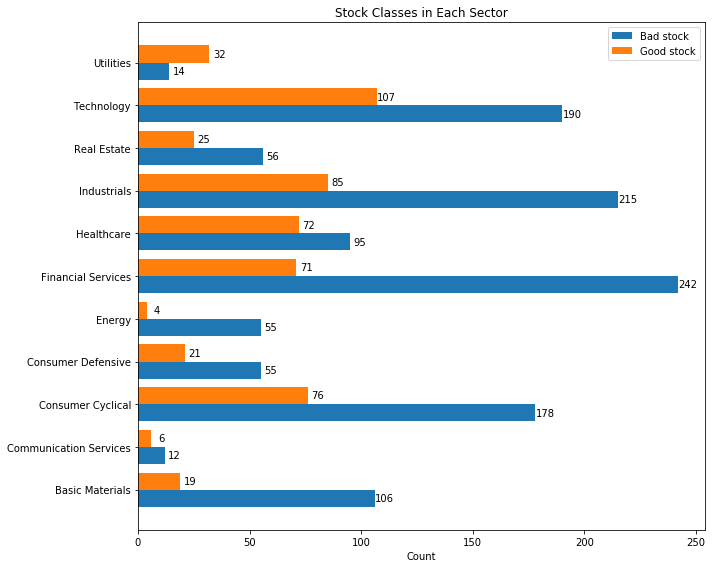

In [19]:
sector_counts_0 = df_2017[df_2017['Class']==0]['Sector'].value_counts().sort_index()
sector_counts_1 = df_2017[df_2017['Class']==1]['Sector'].value_counts().sort_index()

labels = list(sector_counts_0.keys())

y = np.arange(len(labels))
width = 0.4

fig, ax = plt.subplots(figsize=(10,8))

rects1 = ax.barh(y - width/2, sector_counts_0.values, width, label='Bad stock')
rects2 = ax.barh(y + width/2, sector_counts_1.values, width, label='Good stock')

ax.set_title("Stock Classes in Each Sector")
ax.set_xlabel('Count')
ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        width = rect.get_width()
        ax.annotate('{}'.format(width),
                    xy=(width, rect.get_y() + rect.get_height()/2),
                    xytext=(10,0),
                    textcoords='offset points',
                    ha='center',
                    va='center')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
#fig.savefig('final_sector_plot-cleaned.png', dpi=100)
plt.show

## Data Preprocessing

### 1) Feature selection
Since we have 141 feature columns, it is hard for modeling for several reasons. For one, irrelevant features may have negative impacts on model performance. For another, they can result in overfitting and further reduce model accuracy. Lastly, unnecessary data complicates the algorithm and increase computing time. 

Here we will select important features using the 'feature_importance_' score by scikit-learn Decision Tree Classifier. * For the consistency, we will use random 
state = 314 for the analysis. 

In [20]:
from sklearn.tree import DecisionTreeClassifier

label = df_2017['Class']
features = df_2017.drop(['2018 PRICE VAR [%]','Class','Sector'], axis=1)
seed = 120

dt_model = DecisionTreeClassifier(random_state=seed, class_weight='balanced')
dt_model.fit(features, label)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=120, splitter='best')

In [21]:
features.columns

Index(['Revenue', 'Revenue Growth', 'Cost of Revenue', 'Gross Profit',
       'R&D Expenses', 'SG&A Expense', 'Operating Expenses',
       'Operating Income', 'Interest Expense', 'Earnings before Tax',
       ...
       'Dividends per Share Growth', 'Operating Cash Flow growth',
       'Free Cash Flow growth', 'Receivables growth', 'Inventory Growth',
       'Asset Growth', 'Book Value per Share Growth', 'Debt Growth',
       'R&D Expense Growth', 'SG&A Expenses Growth'],
      dtype='object', length=140)

#### Top 10 importance features based on the importance score of decision tree classifier

In [22]:
pd.Series(dt_model.feature_importances_,index=features.columns).sort_values(ascending=False).head(10)

SG&A to Revenue                   0.035996
Capital Expenditure               0.033220
grossProfitMargin                 0.026815
Tangible Book Value per Share     0.025769
Investment purchases and sales    0.024888
Deferred revenue                  0.021069
Income Quality                    0.020191
Income Tax Expense                0.019238
priceToFreeCashFlowsRatio         0.019058
Gross Profit Growth               0.018755
dtype: float64

**Make a plot to visualize top 10 important features**

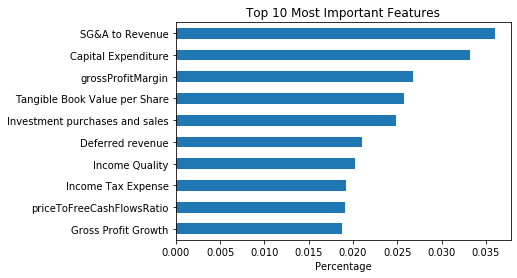

In [23]:
plt.figsize=(8,8)

feat_imp = pd.Series(dt_model.feature_importances_, index=features.columns)
feat_imp.nlargest(10).sort_values(ascending=True).plot(kind='barh')
plt.xlabel("Percentage")
plt.title("Top 10 Most Important Features")

plt.show()

In the following analysis, we will use the above 10 features along with sectors to perform decision tree learning.

In [24]:
feat_cols = list(feat_imp.nlargest(10).index)

### 2) Feature scaling
#### Scale numerical variables
Since each feature is on different scales, we standardize the data with z-transformation.

In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
feat_scaled = scaler.fit_transform(df_2017[feat_cols])

Build a dataframe from scaled numerical columns

In [26]:
df_scaled_nums = pd.DataFrame(feat_scaled, columns=feat_cols, index=df_2017.index)

Summary statistics of the scaled columns:

The standard deviation of each feature is now around 1.

In [27]:
df_scaled_nums.describe()

,SG&A to Revenue,Capital Expenditure,grossProfitMargin,Tangible Book Value per Share,Investment purchases and sales,Deferred revenue,Income Quality,Income Tax Expense,priceToFreeCashFlowsRatio,Gross Profit Growth
count,1.736000e+03,1.736000e+03,1.736000e+03,1.736000e+03,1.736000e+03,1.736000e+03,1.736000e+03,1.736000e+03,1.736000e+03,1.736000e+03
mean,1.052665e-16,-3.453459e-17,-8.339463e-16,-3.042241e-16,-7.563394e-16,-5.545839e-16,-8.556903e-17,-2.238353e-17,5.372047e-17,4.719727e-17
std,1.000288e+00,1.000288e+00,1.000288e+00,1.000288e+00,1.000288e+00,1.000288e+00,1.000288e+00,1.000288e+00,1.000288e+00,1.000288e+00
min,-5.994839e-01,-1.139715e+01,-1.677662e+00,-6.906248e-01,-1.690171e+01,-2.526335e-01,-5.953385e+00,-5.201317e+00,-6.601059e-01,-1.909827e+00
25%,-3.846665e-01,7.499110e-02,-8.119573e-01,-5.638727e-01,1.439844e-01,-2.526335e-01,-2.147753e-01,-2.819460e-01,-5.836490e-01,-3.268203e-01
50%,-1.646096e-01,3.183791e-01,-2.597866e-01,-3.835453e-01,1.864447e-01,-2.526335e-01,-2.859813e-02,-2.393241e-01,-2.158286e-01,-1.871060e-01
75%,1.819894e-01,3.778358e-01,7.497637e-01,5.905976e-02,1.864447e-01,-2.227903e-01,1.819626e-01,-4.896527e-03,9.228756e-02,5.533931e-02
max,2.703637e+01,3.892663e-01,1.683853e+00,6.322459e+00,4.106695e+00,1.013336e+01,1.110955e+01,1.312738e+01,9.624461e+00,1.790642e+01


### 3) Encode categorical variables

#### One Hot Encoding Sector Variable

In [28]:
df_2017_one_hot = pd.get_dummies(df_2017['Sector'], drop_first=True)
print(df_2017_one_hot.columns)
print("Number of sector dummies:",len(df_2017_one_hot.columns))

Index(['Communication Services', 'Consumer Cyclical', 'Consumer Defensive',
       'Energy', 'Financial Services', 'Healthcare', 'Industrials',
       'Real Estate', 'Technology', 'Utilities'],
      dtype='object')
Number of sector dummies: 10


#### Build a dataframe with standardized features, one-hot columns, and Class

In [29]:
df_2017_final = df_scaled_nums.join(df_2017['Class'])
df_2017_final = df_2017_final.join(df_2017_one_hot)

print(f"Dimension of the final dataframe: \n{df_2017_final.shape}")

Dimension of the final dataframe: 
(1736, 21)


A quick overview of the final dataset to be analyzed.

In [30]:
df_2017_final.head(5)

,SG&A to Revenue,Capital Expenditure,grossProfitMargin,Tangible Book Value per Share,Investment purchases and sales,Deferred revenue,Income Quality,Income Tax Expense,priceToFreeCashFlowsRatio,Gross Profit Growth,Class,Communication Services,Consumer Cyclical,Consumer Defensive,Energy,Financial Services,Healthcare,Industrials,Real Estate,Technology,Utilities
GIS,-0.253493,-1.524127,-0.543066,-0.492119,0.227677,-0.252634,-0.023843,3.291392,-0.110821,-0.433871,0,0,0,1,0,0,0,0,0,0,0
BRFS,-0.290731,-0.684273,-1.078353,-0.499372,0.506395,-0.252634,-1.190481,-0.696721,-0.488411,-0.743013,0,0,0,1,0,0,0,0,0,0,0
CPB,-0.239459,-0.561523,-0.328840,-0.493277,0.186445,-0.252634,-0.025190,1.855943,-0.164150,-0.689066,0,0,0,1,0,0,0,0,0,0,0
HRL,-0.443985,-0.222648,-1.020434,-0.597707,0.186445,-0.252634,-0.087455,2.071599,-0.089511,-0.490558,1,0,0,1,0,0,0,0,0,0,0
K,-0.117267,-1.020040,-0.511544,-0.408788,4.106695,-0.252634,-0.329836,1.954112,-0.660106,-0.398047,0,0,0,1,0,0,0,0,0,0,0


## Perform classification with Decision Tree Analysis

### 1) Split train, validation, and test dataset
To find out the best combination of parameters, we use part of the train dataset as validation datasets. The proportion of train and test dataset are 80/20. We also constructed a validation dataset, which is 10% of the train dataset, to test the generalizability of the model. We shuffle our data before splitting to prevent the trend of the dataframe from biasing the result.

In [31]:
from sklearn.model_selection import train_test_split

features, label = df_2017_final.drop('Class',axis=1), df_2017_final['Class']

test_size = 0.2
val_size = 0.1

X_train_val, X_test, y_train_val, y_test = train_test_split(features, label, test_size=test_size, random_state=seed, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size, random_state=seed, shuffle=True)

print(f"Training samples: {len(X_train)}\nValidation samples: {len(X_val)}\nTest samples: {len(X_test)}")

Training samples: 1249
Validation samples: 139
Test samples: 348


### 2) Dealing with overfitting issue
Sometimes one model may have very high accuracy on original data but returns low accuary on other data. Overfitting results in poor prediction. To make sure our model is not overfitting, we have to **find the maximum depth that generates best accuracy for both train and validation datasets.**

In [32]:
max_dept_options = list(range(1,10))

train_accuracy = []
val_accuracy = []

for i in max_dept_options:
    dt_model = DecisionTreeClassifier(criterion='gini', max_depth=i,class_weight='balanced', random_state=seed)
    dt_model.fit(X_train,y_train)
    train_acc = dt_model.score(X_train, y_train)
    val_acc = dt_model.score(X_val, y_val)
    train_accuracy.append(train_acc)
    val_accuracy.append(val_acc)

#### Plot the train and validation curve with regards to different max depth options.

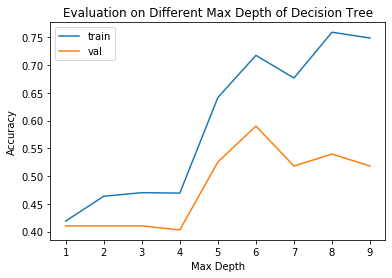

In [33]:
plt.plot(max_dept_options, train_accuracy, label='train')
plt.plot(max_dept_options, val_accuracy, label='val')
plt.title("Evaluation on Different Max Depth of Decision Tree")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

The accuracy of train dataset increases as the depth of the tree increases, while the accuracy of validation dataset starts falling below its highest number (69%) once tree depth goes over 4. This means the ability of generalization decreases when the tree splits more than 4 times. Therefore, in the following analysis, we will test different combinations of parameters with maximum depth less than 4.

### 3) Evaluation with DT analysis
#### Hyperparameter tuning
We performed a 5-fold Grid Search Cross Validation to try out the best combination of different parameters. In the parameter grid, we input a range of maximum depth from 1 to 4, a range of minimum samples split from 2 to 10. In addition, we also tests the function to evaluate the quality of the split - gini (impurity) and entropy (information gain). Lastly, we set the class weight to balanced to account for the effect of different proportion of each class value.

In [34]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth'        : list(range(1,7)),
    'criterion'        : ['gini','entropy'],
    'min_samples_split': list(range(2,10)),
    'class_weight'     : ['balanced']
}

In [35]:
dt_model = DecisionTreeClassifier(random_state=seed)
dt_model_grid = GridSearchCV(dt_model, param_grid, cv=5, n_jobs=-1) # n_jobs=-1 to use all processors

dt_model_grid.fit(X_train_val, y_train_val)

C:\Users\hhyao\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=120,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'criterion': ['gini', 'entropy'],
                         

#### Estimate of generalization performance

In [36]:
from sklearn.model_selection import cross_val_score

cross_val_score(dt_model,X_train_val,y_train_val,cv=5)

array([0.54480287, 0.6294964 , 0.6101083 , 0.60649819, 0.62454874])

The first fold of cross validation returns the best score.

In [37]:
dt_model_1 = dt_model_grid.best_estimator_
dt_model_1

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=9,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=120, splitter='best')

In [38]:
print(dt_model_grid.best_score_)

0.6404899135446686


In [39]:
print(f"Train accuracy: {dt_model_1.score(X_train_val,y_train_val)}")
print(f"Test accuracy: {dt_model_1.score(X_test,y_test)}")

Train accuracy: 0.6909221902017291
Test accuracy: 0.6522988505747126


In [40]:
from sklearn.metrics import classification_report

preds = dt_model_1.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.75      0.78      0.76       252
           1       0.36      0.32      0.34        96

    accuracy                           0.65       348
   macro avg       0.55      0.55      0.55       348
weighted avg       0.64      0.65      0.65       348



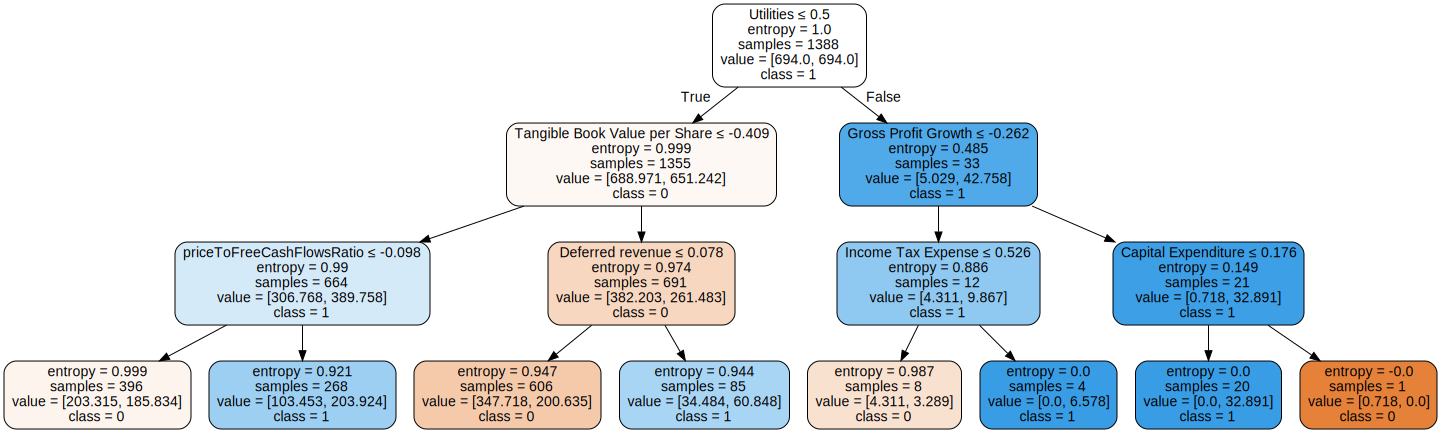

In [41]:
import graphviz 
from sklearn import tree
import os

feature_names = list(X_test.columns)
feature_names[0] = 'SGnA to Revenue' # tree plot cannot print symbols
class_names = ['0', '1']
dot_data = tree.export_graphviz(dt_model_1, out_file=None,feature_names=feature_names,\
                                class_names=class_names, filled=True,\
                                rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

#### Save trained model

In [42]:
from joblib import dump,load

dump(dt_model_1,'dt_model_1.joblib')

['dt_model_1.joblib']

### 4) Modify the model

As we see in the graph of sector distribution, the utilities sector has different trend with other sectors. It could be the outlier of our data. We thus trained another model without sector. 

In [43]:
features_new = df_2017_final[feat_cols]

X_train_val, X_test, y_train_val, y_test = train_test_split(features_new, label, test_size=test_size, random_state=seed, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size, random_state=seed, shuffle=True)

print(f"Training samples: {len(X_train)}\nValidation samples: {len(X_val)}\nTest samples: {len(X_test)}")

Training samples: 1249
Validation samples: 139
Test samples: 348


In [44]:
max_dept_options = list(range(1,10))

train_accuracy = []
val_accuracy = []

for i in max_dept_options:
    dt_model = DecisionTreeClassifier(criterion='gini', max_depth=i, class_weight='balanced', random_state=seed)
    dt_model.fit(X_train,y_train)
    train_acc = dt_model.score(X_train, y_train)
    val_acc = dt_model.score(X_val, y_val)
    train_accuracy.append(train_acc)
    val_accuracy.append(val_acc)

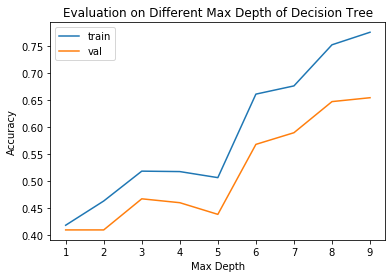

In [45]:
plt.plot(max_dept_options, train_accuracy, label='train')
plt.plot(max_dept_options, val_accuracy, label='val')
plt.title("Evaluation on Different Max Depth of Decision Tree")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.legend()

plt.savefig("final_eval.png",dpi=100)
plt.show()

The ability of generalization decreases with deeper splits.

In [46]:
param_grid = {
    'max_depth'        : list(range(1,7)),
    'criterion'        : ['gini','entropy'],
    'min_samples_split': list(range(2,10)),
    'class_weight'     : ['balanced']
}

In [47]:
dt_model = DecisionTreeClassifier(random_state=seed)
dt_model_grid = GridSearchCV(dt_model, param_grid, cv=5, n_jobs=-1)

dt_model_grid.fit(X_train_val, y_train_val)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=120,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'criterion': ['gini', 'entropy'],
                         

In [48]:
dt_model_2 = dt_model_grid.best_estimator_
dt_model_2

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=120, splitter='best')

In [49]:
print(dt_model_grid.best_score_)

0.5842939481268011


In [50]:
print(f"Train accuracy: {dt_model_2.score(X_train_val,y_train_val)}")
print(f"Test accuracy: {dt_model_2.score(X_test,y_test)}")

Train accuracy: 0.638328530259366
Test accuracy: 0.6293103448275862


In [51]:
preds = dt_model_2.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.76      0.72      0.74       252
           1       0.35      0.39      0.36        96

    accuracy                           0.63       348
   macro avg       0.55      0.55      0.55       348
weighted avg       0.64      0.63      0.64       348



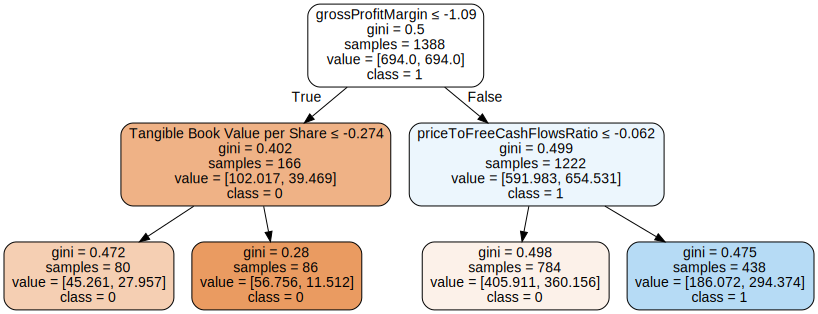

In [52]:
feature_names = list(X_test.columns)
feature_names[0] = 'SGnA to Revenue' # tree plot cannot print symbols
class_names = ['0', '1']
dot_data = tree.export_graphviz(dt_model_2, out_file=None,feature_names=feature_names,\
                                class_names=class_names, filled=True,\
                                rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

#### Save the second trained model

In [53]:
dump(dt_model_2,'dt_model_2.joblib')

['dt_model_2.joblib']

## Evaluate models with data from other years

### Load Data

In [54]:
df_2018 = files_list[4]

In [55]:
df_2018.shape

(4392, 224)

### Clean data

Drop duplicate coulmns, unrepresentative columns, rows with missing values, and extreme outliers.

In [56]:
df_2018 = df_2018.T.drop_duplicates().T.infer_objects()
df_2018.drop(['Current ratio','dividendYield','netProfitMargin'], axis=1,inplace=True)

In [57]:
df_2018.drop(unrep_cols, axis=1,inplace=True)
df_2018.dropna(axis=0,how='any',inplace=True)

P1 = df_2018.quantile(0.01)
P99 = df_2018.quantile(0.99)

df_2018 = df_2018[~((df_2018 < P1) | (df_2018 > P99)).any(axis=1)]

In [58]:
print(f"Dimension of after removing outliers dataset: {df_2018.shape}")

Dimension of after removing outliers dataset: (1769, 143)


### Overview of 2018 dataset

#### Distribution of stock class

In [59]:
df_2018['Class'].value_counts()

1    1330
0     439
Name: Class, dtype: int64

<function matplotlib.pyplot.show(*args, **kw)>

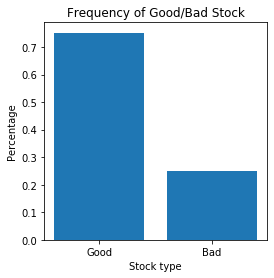

In [70]:
plt.figure(figsize=(4,4))
class_perc = df_2018['Class'].value_counts()/len(df_2018)
# Notes 70% of stocks are bad stocks

plt.bar(range(2), class_perc.values)
plt.title("Frequency of Good/Bad Stock")
plt.xticks(range(2),("Good","Bad"))
plt.xlabel("Stock type")
plt.ylabel("Percentage")

plt.show

#### Distribution of sectors

<function matplotlib.pyplot.show(*args, **kw)>

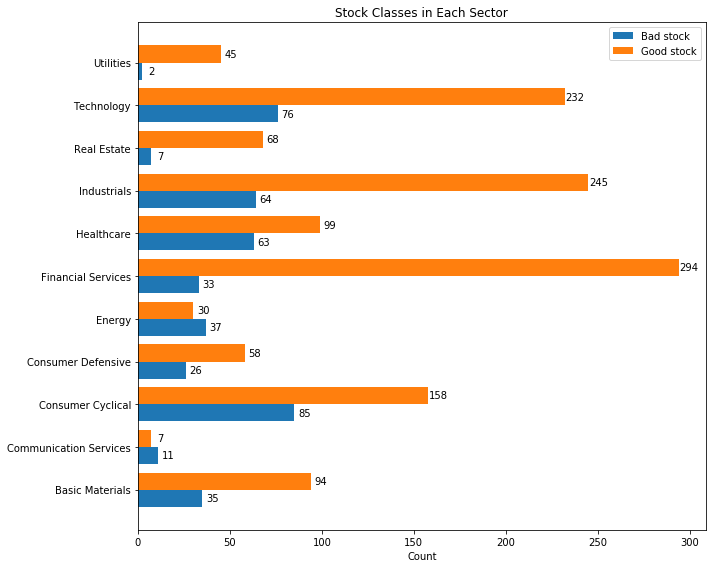

In [61]:
sector_counts_0 = df_2018[df_2018['Class']==0]['Sector'].value_counts().sort_index()
sector_counts_1 = df_2018[df_2018['Class']==1]['Sector'].value_counts().sort_index()

labels = list(sector_counts_0.keys())

y = np.arange(len(labels))
width = 0.4

fig, ax = plt.subplots(figsize=(10,8))

rects1 = ax.barh(y - width/2, sector_counts_0.values, width, label='Bad stock')
rects2 = ax.barh(y + width/2, sector_counts_1.values, width, label='Good stock')

ax.set_title("Stock Classes in Each Sector")
ax.set_xlabel('Count')
ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        width = rect.get_width()
        ax.annotate('{}'.format(width),
                    xy=(width, rect.get_y() + rect.get_height()/2),
                    xytext=(10,0),
                    textcoords='offset points',
                    ha='center',
                    va='center')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show

### Preprocessing

#### 1) Select importance features & standardize the numeric features
Here we selected the top 10 important feature we found based on the initial decision tree analysis of 2017 data. 

In [62]:
feat_scaled = scaler.fit_transform(df_2018[feat_cols])

# Make it into a pandas dataframe for further joining
df_scaled_nums = pd.DataFrame(feat_scaled, columns=feat_cols, index=df_2018.index)

#### 2) One-hot encode categorical variable

In [63]:
df_2018_one_hot = pd.get_dummies(df_2018['Sector'], drop_first=True)

# join with scaled features and class
df_2018_final = df_scaled_nums.join(df_2018['Class'])
df_2018_final = df_2018_final.join(df_2018_one_hot)

### Load saved DT models

In [64]:
dt_model_1 = load('dt_model_1.joblib')
dt_model_2 = load('dt_model_2.joblib')

In [65]:
X, y = df_2018_final.drop('Class',axis=1), df_2018_final['Class']
X_no_sector = df_2018_final[feat_cols]

#### Test accuracy

In [66]:
dt_model_1.score(X,y)

0.38552854720180896

In [67]:
preds = dt_model_1.predict(X)
print(classification_report(y, preds))

              precision    recall  f1-score   support

           0       0.25      0.74      0.37       439
           1       0.76      0.27      0.40      1330

    accuracy                           0.39      1769
   macro avg       0.50      0.50      0.39      1769
weighted avg       0.63      0.39      0.39      1769



In [68]:
dt_model_2.score(X_no_sector,y)

0.42227247032221593

In [69]:
preds = dt_model_2.predict(X_no_sector)
print(classification_report(y, preds))

              precision    recall  f1-score   support

           0       0.26      0.73      0.39       439
           1       0.78      0.32      0.45      1330

    accuracy                           0.42      1769
   macro avg       0.52      0.53      0.42      1769
weighted avg       0.65      0.42      0.44      1769



(The end.)